# Location Clustering with geo2vec - an example

This notebook contains an example of how the different parts of the model interact and a run separately.

In [1]:
import os.path
import sys
import json
import pickle

import pandas as pd
import geopandas as gpd
import numpy as np

r_path = "../src/utils/"
sys.path.append(r_path)

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# General simulation parameters
# to run, insert usename to access database
username = "USERNAME"
season = 'winter'
country = 'all'

In [4]:
# load location data
from load_data import load_dataframes as load_df

if country == 'all':
    df_trips = load_df.get_geo2vec_data_all_country(username, season).rename(columns={'com_locs_trunc':'locations'})
else:
    df_trips = load_df.get_geo2vec_data(username, season, country).rename(columns={'com_locs_trunc':'locations'})

# geolocation preprocessing
sys.path.append(r_path+'geolocation/')

import preprocessing 
preprocessing.str_to_list(df_trips)
df_trips_red = preprocessing.filter_short_trips(df_trips, min_length=0)
preprocessing.descriptive_sanity_check(df_trips_red)


Number of individual trips: 1041546

Reduced number of individual trips: 1041546

Mean number of visited municipalities = 6.13
Median number of visited municipalities = 5
Min number of visited municipalities = 1
Max number of visited municipalities = 249


In [5]:
# load data from shape files
from read_shapefiles import read_files

path_shapefiles, regions, provinces, territories, municipalities, crs = read_files.read_shapefile_data(r_path+'read_shapefiles/', 'shape_files_path.json')
df_mun = read_files.read_shapefiles_in(False, path_shapefiles, municipalities, crs)
df_mun_tus = read_files.read_shapefiles_in(True, path_shapefiles, municipalities, crs)
df_ter_tus = read_files.read_shapefiles_in(True, path_shapefiles, territories, crs, apply_crs=False)

In [8]:
# save a sample of 50 rows in the folder 'examples'
sample_path = '../examples/sample_location_trips_{}_{}.csv'.format(season,country)
df_trips_red.sample(n=50).to_csv(sample_path)

In [7]:
# create one geo2vec model 
sys.path.append("../src/models/geo2vec/")
from geo2vec import Geo2vec

EMB_SIZE=10
WINDOW_SIZE=5

g2v = Geo2vec(EMB_SIZE, WINDOW_SIZE, season, country)

In [10]:
# initialize model
g2v.initialize(df_trips_red['locations_list'])


Geo2vec model has already been initialized. Loading previously initialized model...


In [11]:
# train model
N_EPOCHS = 100
g2v.train(df_trips_red['locations_list'], n_epochs=N_EPOCHS)


Geo2vec model has already been trained. Loading previously trained model...


In [12]:
# load model
g2v.load(n_epochs_trained=100)

# print model parameters
g2v.print_params()

Model emb10_wind5_epochs100 successfully loaded.


Geo2vec model details:

Model name: emb10_wind5_epochs100
Season: winter
Country: all
Window Size = 5
Embedding dimension = 10
Trained epochs = 100


Number of clusters: 60
Number of clusters: 23


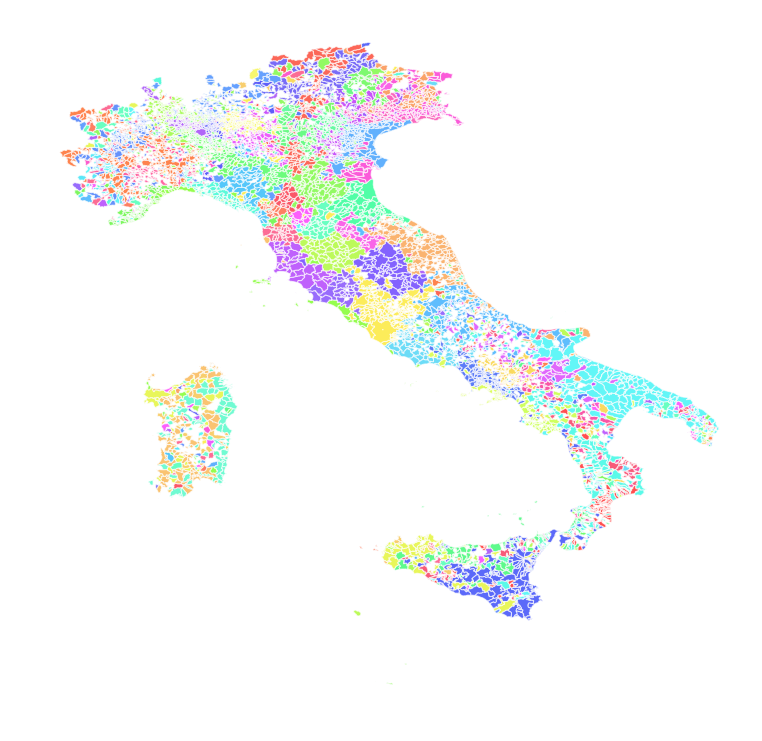

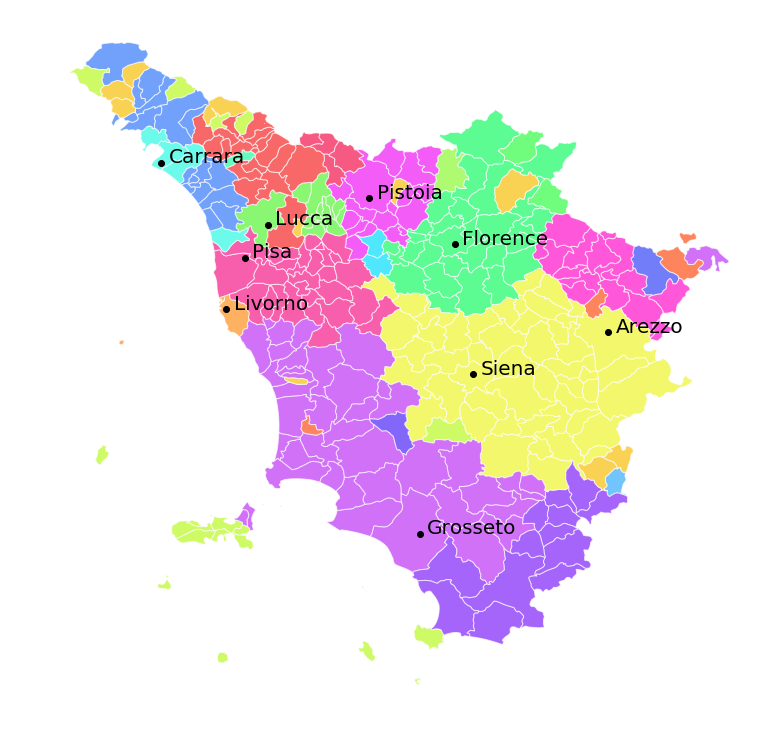

In [49]:
# cluster model

N_CLUSTERS=60

sys.path.append("../viz")
from maps import LocationsClustermap

g2v.create_clusters(n_clusters=N_CLUSTERS)

# save clusters for Italy
g2v.merge_gdf(df_mun)
clustermap_italy = LocationsClustermap(g2v.gdf_clusters)
clustermap_italy.plot('labels', save=False)

# save clusters for Tuscany
g2v.merge_gdf(df_mun_tus)
clustermap_tuscany = LocationsClustermap(g2v.gdf_clusters)
clustermap_tuscany.important_cities()
clustermap_tuscany.plot('labels', save=False)


Calculating t-SNE... (this may take a few minutes)


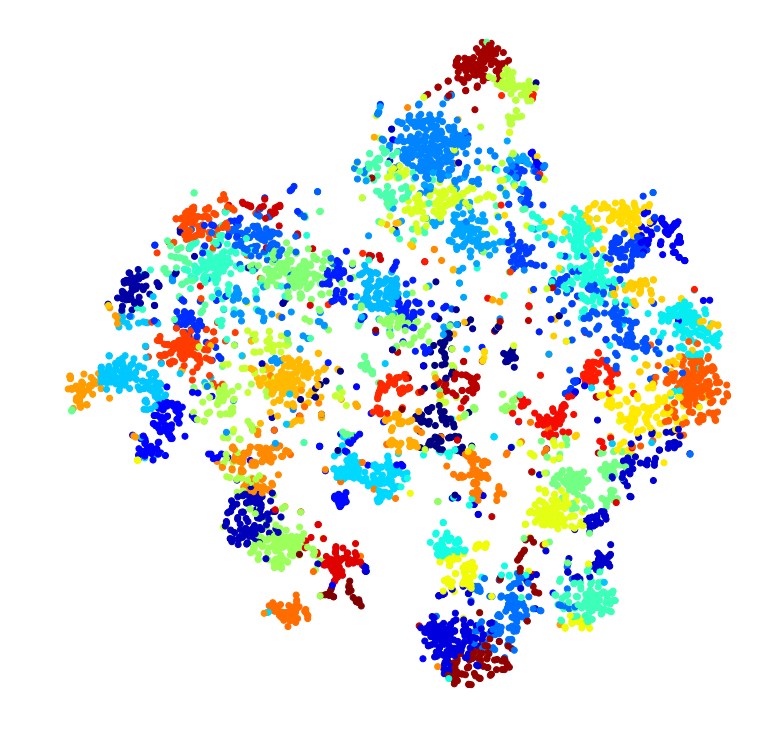

In [16]:
# Apply t-SNE to visualize the clusters
g2v.apply_tsne_2D()
g2v.plot_tsne_2D(save=False)